# Unknowns greater than 120 amino acids 

Use only sequences greater than 120 amino acids - minimum for protein domain

In [1]:
#imports 
#imports 
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from Bio import SeqIO
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker

In [2]:
#read in the sequences embedded with mini bacillus model 
embedding_bacter_s = pd.read_csv('../../embedded_sequences/bacillus_unknown_embedded.csv', sep = '\t')
embedding_bacter = embedding_bacter_s.dropna()
embedding_bacter = embedding_bacter.sort_values(by=['Unnamed: 0'])
bacter_keys = list(embedding_bacter['Unnamed: 0'].values)

#standardise the embedding 
embedding_scaled = StandardScaler().fit_transform(embedding_bacter.drop(['Unnamed: 0'], axis = 1).values)

### Elbow plot to determine the number of clusters

In [ ]:
embedding_sample = embedding_scaled[0:5000]

Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    #print('K: ' + str(k))
    km = KMeans(n_clusters=k)
    km = km.fit(embedding_sample)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
sum_squares = pd.DataFrame({"k": K,  'sum squares':Sum_of_squared_distances})
sns.set(font_scale = 2)
fig, ax = plt.subplots(1, 1, figsize = (15,10))
sns.lineplot( data=sum_squares, x = 'k', y = 'sum squares', color = '#FFB944', linewidth = 8)
ax.set_facecolor('white')
plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Within Cluster Sum of Squares', fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.savefig("elbow.png")

# Visualise all the sequneces

In [ ]:
Kmeans_model = KMeans(n_clusters=12, random_state=0)
Kmeans_model.fit(embedding_scaled)
Kmeans_labels = Kmeans_model.labels_ 

#do the tSNE
tsne = TSNE(perplexity = 30, learning_rate =200)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#colour by subclass 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['dimension 1', 'dimension 2'])
tsne_df.index = bacter_keys
tsne_df['Kmeans'] = Kmeans_labels

plt.figure(figsize=(12,8))
sns.scatterplot(x = 'dimension 1', y = 'dimension 2',hue = 'Kmeans', 
                
                data = tsne_df, legend = 'full', s = 7,linewidth=0, alpha = 0.7, palette = 'tab20' )
plt.legend([],[], frameon=False)

In [ ]:
label_df = pd.DataFrame({'md5': bacter_keys,'label': Kmeans_labels})
ex = label_df[label_df['label'] == 4]['md5'].values

embedding_scaled_df = pd.DataFrame(embedding_scaled, index = bacter_keys)
ex_embedding = embedding_scaled_df.loc[ex]
ex_embedding.values.var()

#repeat this to get the variance within each of the clusters  

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                
                data = tsne_df, legend = 'full', s = 7,linewidth=0, alpha = 0.7, palette = 'tab20' )
plt.legend([],[], frameon=False)

In [ ]:
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

### Do tSNE on the unknown sequences

Text(0, 0.5, 'Dimension 2')

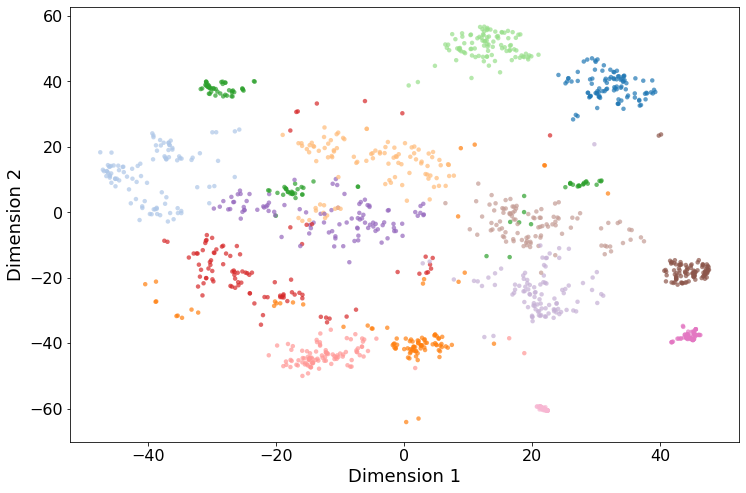

In [22]:
Kmeans_model = KMeans(n_clusters=12, random_state=0)
Kmeans_model.fit(embedding_scaled)
Kmeans_labels = Kmeans_model.labels_ 

#do the tSNE
tsne = TSNE(perplexity = 30, learning_rate =200)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#colour by subclass 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['dimension 1', 'dimension 2'])
tsne_df.index = bacter_keys

#set the number of clusters to be displayed 
k = 14

Kmeans_model = KMeans(n_clusters=k, random_state=0)
Kmeans_model.fit(embedding_scaled)
Kmeans_labels = Kmeans_model.labels_ 

#get the kmeans centres
Kmeans_centres = Kmeans_model.cluster_centers_

# euclidean distance from each point to each cluster centroid
D = cdist(embedding_scaled, Kmeans_centres, 'euclidean')

centroid_list = []
dist_list = [] 

for i in range(len(D)): 
    dist = np.min(D[i])
    cent = np.where(D[i] == D[i].min())[0][0]
    
    #add distance and centroid information 
    dist_list.append(dist)
    centroid_list.append(cent)
    
#assemble into a dataframe 
Kmeans_info = pd.DataFrame({'md5': bacter_keys, 'centroid': centroid_list, 'dist': dist_list})

#get the 50 sequences closest to the centroid 
close_md5s = []
close_centroids = []

for i in range(0,k): 
    
    #get a 'sub' dataframe corresponding to the centroid 
    this_centroid = Kmeans_info[Kmeans_info['centroid'] == i].sort_values('dist').reset_index()
    
    #get the top 100 md5 sums 
    this_md5 = this_centroid[0:100]['md5'].values
    
    #add these md5s to list
    for md5 in this_md5: 
        close_md5s.append(md5)
        close_centroids.append(i)
        
        
close_md5_centroid = pd.DataFrame({'md5': close_md5s, 'centroid': close_centroids})
close_md5_centroid = close_md5_centroid.sort_values('md5')

embedding_close_tsnedf = tsne_df.loc[close_md5_centroid['md5']]
embedding_close_tsnedf['Kmeans'] = close_md5_centroid['centroid'].values

plt.figure(figsize=(12,8))
sns.scatterplot(x = 'dimension 1', y = 'dimension 2',hue = 'Kmeans', 
                
                data = embedding_close_tsnedf, legend = 'full', s = 20,linewidth=0, alpha = 0.7, palette = 'tab20' )
plt.legend([],[], frameon=False)
plt.xlabel('Dimension 1', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dimension 2', fontsize=18)